# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: 18 марта 00:00

Мягкий дедлайн: 1 апреля 23:59 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet. 

Ссылка на данные: https://yadi.sk/d/-ug82uwhSuLYrA

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

import os
from skimage import io
import numpy as np
from PIL import Image
from torch.optim import Adam
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm

import pickle
import utils

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device, torch.cuda.get_device_name())

cuda:0 NVIDIA GeForce GTX 1080 Ti


In [3]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms
        
    def __len__(self):
        return len(os.listdir(path=self.images_dir))
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        if idx < 0 or idx >= self.__len__():
            raise IndexError('Invalid index')
        for index, (image, mask) in enumerate(zip(os.listdir(path=self.images_dir), os.listdir(path=self.target_dir))):
            if index == idx:
                trans_tensor = transforms.ToTensor()
                trans_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                img_res = trans_norm(trans_tensor(Image.open(os.path.join(self.images_dir, image))))
                mask_res = trans_tensor(Image.open(os.path.join(self.target_dir, mask)))
                return img_res, mask_res

In [4]:
d = PhotosDataset(images_dir='people_data/train', target_dir='people_data/train_mask')

In [5]:
d[0]

(tensor([[[1.4612, 1.4612, 1.4612,  ..., 1.1358, 1.2043, 1.2728],
          [1.4440, 1.4612, 1.4612,  ..., 1.1529, 1.2043, 1.2385],
          [1.4440, 1.4440, 1.4440,  ..., 1.1700, 1.2214, 1.2214],
          ...,
          [1.3927, 1.3927, 1.3927,  ..., 1.4098, 1.3927, 1.3927],
          [1.3927, 1.3755, 1.3755,  ..., 1.3927, 1.3755, 1.3584],
          [1.3755, 1.3755, 1.3755,  ..., 1.3927, 1.3584, 1.3413]],
 
         [[1.5882, 1.5882, 1.5882,  ..., 1.1681, 1.2381, 1.3081],
          [1.5707, 1.5882, 1.5882,  ..., 1.1856, 1.2381, 1.2731],
          [1.5707, 1.5707, 1.5707,  ..., 1.2031, 1.2556, 1.2556],
          ...,
          [1.3782, 1.3782, 1.3782,  ..., 1.4132, 1.3957, 1.3957],
          [1.3782, 1.3606, 1.3606,  ..., 1.3957, 1.3782, 1.3606],
          [1.3606, 1.3606, 1.3606,  ..., 1.3957, 1.3606, 1.3431]],
 
         [[1.5768, 1.5768, 1.5768,  ..., 1.0714, 1.1411, 1.2108],
          [1.5594, 1.5768, 1.5768,  ..., 1.0888, 1.1411, 1.1759],
          [1.5594, 1.5594, 1.5594,  ...,

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [6]:
class HorizontalFlip:
    
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img):
        return img.rotate(self.degree)

In [7]:
class Crop:
    
    def __init__(self, left, upper, right, lower):
        self.left = left
        self.upper = upper
        self.right = right
        self.lower = lower
        
    def __call__(self, img):
        return img.crop((self.left, self.upper, self.right, self.lower)).crop((0, 0, 240, 320))

In [8]:
class ChangeBrightness:
    
    def __init__(self, coef):
        self.coef = coef
        
    def __call__(self, img):
        return img.point(lambda x: x * self.coef)

In [9]:
class ChangeBack:
    
    def __init__(self, img2):
        self.img2 = img2
        
    def __call__(self, img):
        return Image.blend(img, self.img2, alpha=0.2)

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [6]:
DATA_PATH = 'people_data/'

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
)

In [10]:
img_list = [Image.open('people_data/train/1.jpg'), Image.open('people_data/train/2.jpg'), Image.open('people_data/train/3.jpg'),
            Image.open('people_data/train/4.jpg'), Image.open('people_data/train/5.jpg'), Image.open('people_data/train/6.jpg'),
            Image.open('people_data/train/7.jpg'), Image.open('people_data/train/8.jpg'), Image.open('people_data/train/9.jpg')]
for index, image_pair in enumerate(train_dataset):
    vec = np.random.binomial(1, 0.5, 4)
    flip = HorizontalFlip(np.random.uniform(-5, 5))
    crop = Crop(np.random.randint(0, 11), np.random.randint(0, 11), np.random.randint(230, 241), np.random.randint(310, 321))
    br = ChangeBrightness(np.clip(np.random.randn() + 1.0, 0.1, 2.0))
    cb = ChangeBack(img_list[np.random.randint(0, len(img_list))])
    if vec[0]:
        img_flip, mask_flip = flip(image_pair[0]), flip(image_pair[1])
        img_flip.save(fp='people_data/train_aug/' + str(index + 1) + 'flip.jpg')
        mask_flip.save(fp='people_data/train_mask_aug/' + str(index + 1) + 'flip.png')
    if vec[1]:
        img_crop, mask_crop = crop(image_pair[0]), crop(image_pair[1])
        img_crop.save(fp='people_data/train_aug/' + str(index + 1) + 'crop.jpg')
        mask_crop.save(fp='people_data/train_mask_aug/' + str(index + 1) + 'crop.png')
    if vec[2]:
        img_br = br(image_pair[0])
        img_br.save(fp='people_data/train_aug/' + str(index + 1) + 'br.jpg')
        image_pair[1].save(fp='people_data/train_mask_aug/' + str(index + 1) + 'br.png')
    if vec[3]:
        img_cb = cb(image_pair[0])
        img_cb.save(fp='people_data/train_aug/' + str(index + 1) + 'cb.jpg')
        image_pair[1].save(fp='people_data/train_mask_aug/' + str(index + 1) + 'cb.png')

Функция для отображения изображения:

In [11]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

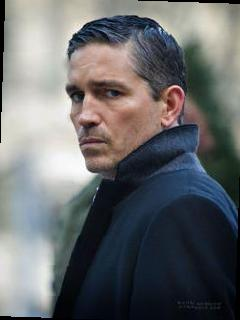

In [37]:
train_dataset[26][0]

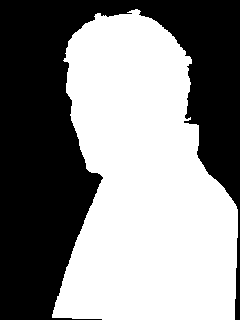

In [38]:
train_dataset[26][1]

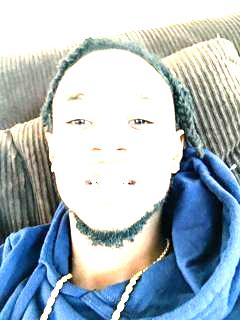

In [50]:
train_dataset[38][0]

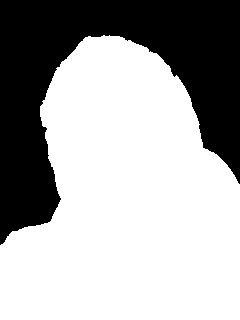

In [51]:
train_dataset[38][1]

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [7]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [8]:
class DiceLoss(nn.Module):
    
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        loss_value = 1 - ((2 * (logits * true_labels).sum(axis=1).sum(axis=1)) / (logits + true_labels + self.eps).sum(axis=1).sum(axis=1))
        
        if self.reduction == 'sum':
            loss_value = loss_value.sum()
        elif self.reduction == 'mean':
            loss_value = loss_value.mean()
            
        return loss_value

In [9]:
class DiceBCELoss(nn.Module):
    
    def __init__(self, eps=1e-7):
        super().__init__()
        self.eps = eps
        self.BCE = nn.BCEWithLogitsLoss()
        
    def forward(self, logits, true_labels):
        # true_labels = true_labels.long()
        loss_value = 0.5 * (1 - ((2 * (torch.sigmoid(logits) * true_labels).sum(axis=1).sum(axis=1)) / (torch.sigmoid(logits) + true_labels + self.eps).sum(axis=1).sum(axis=1))).mean() + 0.5 * self.BCE(logits, true_labels)
        return loss_value

In [10]:
class DiceQual(nn.Module):
    
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        loss_value = ((2 * (logits * true_labels).sum(axis=1).sum(axis=1)) / (logits + true_labels + self.eps).sum(axis=1).sum(axis=1))
        
        if self.reduction == 'sum':
            loss_value = loss_value.sum()
        elif self.reduction == 'mean':
            loss_value = loss_value.mean()
            
        return loss_value

Проверка реализации:

In [11]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet (https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [12]:
class VGG13Encoder(torch.nn.Module):
    
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [13]:
class DecoderBlock(torch.nn.Module):
    
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [14]:
class Decoder(nn.Module):
    
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [15]:
class UNet(torch.nn.Module):
    
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [16]:
def evaluate_net(net, testloader, criterion, val_criterion, device=device):
    net = net.to(device)
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images)
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [23]:
num_epoch = 200
lr = 1e-4
weight_decay = 0
step_size = 50
gamma = 0.5

In [19]:
model = UNet()

In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

cuda:0


In [17]:
def train(model, train_dataloader, device, loss_train=None, loss_test=None, qual_train=None, qual_test=None, name=None):
    model = model.to(device)
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        if loss_train is not None and qual_train is not None:
            l_tr, q_tr = evaluate_net(model, train_data_loader, criterion, val_criterion)
            loss_train.append(l_tr)
            qual_train.append(q_tr)
            print(l_tr, q_tr, sep='   ')
        if loss_test is not None and qual_test is not None:
            l_te, q_te = evaluate_net(model, test_data_loader, criterion, val_criterion)
            loss_test.append(l_te)
            qual_test.append(q_te)
    if name is not None:
        torch.save(model, name)

In [18]:
def val(epoch, model, val_dataloader):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        loss_stat = []
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_stat.append(loss.cpu().item())
    print(f'Loss for epoch {epoch}: {np.mean(loss_stat)}')

In [23]:
train(model, train_data_loader, device)

Loss for epoch 0: 0.1848134481244617
Loss for epoch 1: 0.14408040626181495
Loss for epoch 2: 0.14898084021276897
Loss for epoch 3: 0.16457226541307238
Loss for epoch 4: 0.19483373148573768
Loss for epoch 5: 0.20172112186749777
Loss for epoch 6: 0.2235635668039322
Loss for epoch 7: 0.2763636112213135
Loss for epoch 8: 0.23922710617383322
Loss for epoch 9: 0.27780261801348793
Loss for epoch 10: 0.22358567847145927
Loss for epoch 11: 0.2578380223777559
Loss for epoch 12: 0.28253934118482804
Loss for epoch 13: 0.3131490929259194
Loss for epoch 14: 0.2981583807203505
Loss for epoch 15: 0.24675432840983072
Loss for epoch 16: 0.24446996053059897
Loss for epoch 17: 0.2857098231712977
Loss for epoch 18: 0.3088463462061352
Loss for epoch 19: 0.34518422020806205
Loss for epoch 20: 0.3587295413017273
Loss for epoch 21: 0.2958112706740697
Loss for epoch 22: 0.35487966073883903
Loss for epoch 23: 0.35345564948187935
Loss for epoch 24: 0.39277371101909214
Loss for epoch 25: 0.38649370935228133
Loss f

In [194]:
model = torch.load('models/model1')

In [22]:
model

UNet(
  (encoder): VGG13Encoder(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(512, 512, kernel_siz

In [23]:
evaluate_net(model, test_data_loader, nn.BCEWithLogitsLoss(), DiceQual())

(0.1322456065644609, 0.056026560194948886)

In [195]:
evaluate_net(model, train_data_loader, nn.BCEWithLogitsLoss(), DiceQual())

(8.793744053284914e-05, 0.05650163406069309)

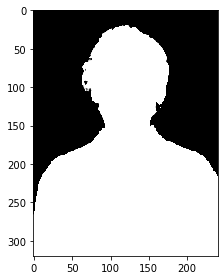

In [25]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[0][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res)
io.show()

In [149]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.1)

In [210]:
net2 = UNet()

In [211]:
num_epoch = 100
lr = 0.001
weight_decay = 0
step_size = 50
gamma = 0.5
criterion = nn.BCEWithLogitsLoss()
val_criterion = DiceQual()
optimizer = torch.optim.Adam(net2.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size)

In [212]:
loss_train = []
loss_test = []
qual_train = []
qual_test = []

In [213]:
train(net2, train_data_loader, device, loss_train=loss_train, loss_test=loss_test, qual_train=qual_train, qual_test=qual_test)

0.026542126635222953   0.041584482429305986
0.02583103741759524   0.041522848740644144
0.024501818128961107   0.04261256771946328
0.021858107441189947   0.04378055394339257
0.021344526461576925   0.04385819610014514
0.02078299370975443   0.04440295064531201
0.020701525599437092   0.04477639837049759
0.020096408274532886   0.044889979013282955
0.020548016523852783   0.04574073886204515
0.02052426747283126   0.04398314102065692
0.019166501873228572   0.045235186010979346
0.01871367178718405   0.04521747980489815
0.020332342618756487   0.04428300483771933
0.01832158067670374   0.04573613595330797
0.018614425695884215   0.04517291177711262
0.01845656067747129   0.04639459112558562
0.018478774451911158   0.04547887673497317
0.017528783592145974   0.0458944380663562
0.017246584560616094   0.046000364440346136
0.017551552299574617   0.04536970598774873
0.0174172963212236   0.04673726015867733
0.017513671017985816   0.045422338512273716
0.016989619771824734   0.0454702018024409
0.0164272484787

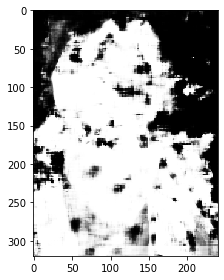

In [232]:
net2 = net2.to(device)
net2.eval()
img = torch.unsqueeze(test_dataset[50][0], 0).to(device)
with torch.no_grad():
    res = net2(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
# res = torch.squeeze(res).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

In [234]:
net3 = UNet()

In [237]:
num_epoch = 200
lr = 0.0001
weight_decay = 0.0001
step_size = 50
gamma = 0.5
criterion = DiceLoss(reduction='mean')
val_criterion = DiceQual()
optimizer = torch.optim.Adam(net3.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_train3 = []
loss_test3 = []
qual_train3 = []
qual_test3 = []

In [238]:
train(net3, train_data_loader, device, loss_train=loss_train3, loss_test=loss_test3, qual_train=qual_train3, qual_test=qual_test3)

0.0082977353663744   0.05426360247062631
0.007886924201456265   0.0546744137973149
0.007727875608230655   0.054833462050548364
0.007672775016733837   0.0548885631520334
0.007307467132192599   0.055253870587821566
0.007374063367252553   0.05518727441765258
0.007093647833076379   0.05546769008435258
0.007044577723418356   0.055516760076110096
0.0070252600678912674   0.05553607787421454
0.007144712244358802   0.055416625574362756
0.007079534182805747   0.0554818037798641
0.007006321554789658   0.055555016167966376
0.007043384446948036   0.05551795355822083
0.006902132319949999   0.05565920555497994
0.006930736148541645   0.05563060174512442
0.006803809671541192   0.055757528183738664
0.006773460460817615   0.055787877315861906
0.006973383082689259   0.05558795459254099
0.006818120921683206   0.055743216868705675
0.006848694001698284   0.055712643985191435
0.00671522696689868   0.055846111039184146
0.006958482372076401   0.055602855417398525
0.006951968182861747   0.05560936946220791
0.006

0.006289976069994337   0.05627136176654939
0.006291437648708354   0.056269900195147035
0.006296142818309345   0.05626519514253259
0.006281566784659564   0.056279771066507486
0.0062701505955246525   0.056291187257013334
0.0064085649986320905   0.05615277282740113
0.00627140517431559   0.05628993267867937
0.006259454186673077   0.05630188352694338
0.0062699142561986   0.05629142345284807
0.006267681917572308   0.05629365576085679



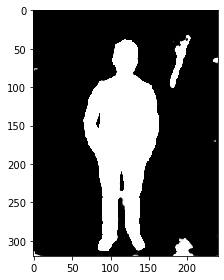

In [276]:
net3 = net3.to(device)
net3.eval()
img = torch.unsqueeze(test_dataset[9][0], 0).to(device)
with torch.no_grad():
    res = net3(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
# res = torch.squeeze(res).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

In [250]:
net4 = UNet()

In [251]:
num_epoch = 200
lr = 0.0001
weight_decay = 0.0001
step_size = 50
gamma = 0.5
criterion = nn.BCEWithLogitsLoss()
val_criterion = DiceQual()
optimizer = torch.optim.Adam(net4.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_train4 = []
loss_test4 = []
qual_train4 = []
qual_test4 = []

In [252]:
train(net4, train_data_loader, device, loss_train=loss_train4, loss_test=loss_test4, qual_train=qual_train4, qual_test=qual_test4, name='models/model4')

0.013023294715011553   0.04995474024832073
0.008768050731237433   0.05173727675497356
0.004702692412724673   0.053088553505744034
0.003749203020057863   0.05367582928210175
0.0028711907406565136   0.05448546745358318
0.002464964876629566   0.05452467632773346
0.002045530428738864   0.05501660596400178
0.0018576686243116272   0.0551153665903857
0.002154613474440616   0.05488166353419438
0.00282961202436241   0.05451672524944957
0.0015083523631695443   0.055313874522299016
0.001472664189043293   0.05538811419850126
0.0012967788561323147   0.05544255043620333
0.0012314074338707155   0.055550544313406454
0.0017060823418689898   0.055216809030954925
0.0012100101626817215   0.055527775412218844
0.0010893490422294056   0.05565030362468004
0.001006027032421048   0.055692060027085065
0.0009739997550402791   0.05572303474475872
0.0010784691260438467   0.05564539820336032
0.0016772193880797428   0.05514593071453237
0.001336942592286619   0.05548369864018322
0.0010082087357518453   0.0556790643866

0.00031429827145883   0.05628419590709956
0.00033595334540621193   0.0562747036480693
0.0003249600074519938   0.05627396324022478
0.0003700697024776011   0.05626118531170958
0.00037150382008531495   0.05623065341735611
0.0003144944064850143   0.056268938478005646
0.0003079540213095655   0.05628086078155263
0.00029711870904335563   0.0562938980546152
0.00031907657141704937   0.056288985584856135
0.0003227121826746593   0.05625726370336497
0.00030497734093768076   0.056284377323984516
0.000291489861150189   0.056295596202058575
0.00029128786594350114   0.05629865434733644
0.0003095282762315055   0.05628786282111197
0.00030702743320556774   0.056285274596162824



In [30]:
net4 = net4.to(device)
net4.eval()
img = torch.unsqueeze(test_dataset[0][0], 0).to(device)
with torch.no_grad():
    res = net4(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
# res = torch.squeeze(res).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

NameError: name 'net4' is not defined

In [254]:
# f = open('lists/loss_train4', 'wb')
# pickle.dump(loss_train4, f)
# f.close()
# f = open('lists/loss_test4', 'wb')
# pickle.dump(loss_test4, f)
# f.close()
# f = open('lists/qual_train4', 'wb')
# pickle.dump(qual_train4, f)
# f.close()
# f = open('lists/qual_test4', 'wb')
# pickle.dump(qual_test4, f)
# f.close()

In [23]:
net5 = UNet()

In [24]:
num_epoch = 150
lr = 0.0001
weight_decay = 0.0001
step_size = 20
gamma = 0.2
criterion = DiceBCELoss()
val_criterion = DiceQual()
optimizer = torch.optim.Adam(net5.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_train5 = []
loss_test5 = []
qual_train5 = []
qual_test5 = []

In [25]:
train(net5, train_data_loader, device, loss_train=loss_train5, loss_test=loss_test5, qual_train=qual_train5, qual_test=qual_test5, name='models/model5')

0.010961282828327368   0.051041786991227946
0.00812195082971053   0.05294351823723
0.0070531696786736596   0.05359761371579792
0.005969972870659021   0.0543600965411904
0.005351987062341975   0.05481992846206781
0.005214071615075398   0.05496130945111631
0.0047756867086600745   0.055226840802684966
0.004682516056762768   0.055242197845822114
0.0044868339540416755   0.05543351781730914
0.004852161039913602   0.05519107528125924
0.004287126834181679   0.055577808276359886
0.004244052870354457   0.055596311233930426
0.004225459411809764   0.055637932165916115
0.0041248125546923505   0.055699043085577445
0.0041308569136030895   0.05570673525801351
0.003970760816911106   0.055814523750713226
0.005946640486411304   0.05420290134020947
0.004141015457620038   0.05568856603380976
0.003896246702612265   0.05586018693341825
0.0038697148611087267   0.05587692356963621
0.0037577701111025266   0.05596681171708299
0.0037305107778002225   0.055990727905319296
0.003714622854747763   0.05599288238802882

In [26]:
f = open('lists/loss_train5', 'wb')
pickle.dump(loss_train5, f)
f.close()
f = open('lists/loss_test5', 'wb')
pickle.dump(loss_test5, f)
f.close()
f = open('lists/qual_train5', 'wb')
pickle.dump(qual_train5, f)
f.close()
f = open('lists/qual_test5', 'wb')
pickle.dump(qual_test5, f)
f.close()

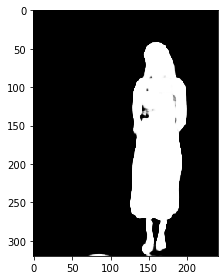

In [42]:
net5 = net5.to(device)
net5.eval()
img = torch.unsqueeze(test_dataset[14][0], 0).to(device)
with torch.no_grad():
    res = net5(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
# res = torch.squeeze(res).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

## UNet c BCEWithLogitsLoss

In [20]:
model = torch.load('models_unet/model4')
f = open('lists_unet/loss_train4', 'rb')
loss_train = pickle.load(f)
f = open('lists_unet/loss_test4', 'rb')
loss_test = pickle.load(f)
f = open('lists_unet/qual_train4', 'rb')
qual_train = pickle.load(f)
f = open('lists_unet/qual_test4', 'rb')
qual_test = pickle.load(f)
f.close()

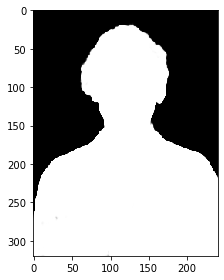

In [21]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[0][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

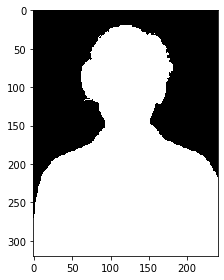

In [25]:
io.imshow(torch.squeeze(test_dataset[0][1]).numpy(), cmap='gray')
io.show()

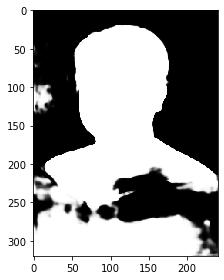

In [26]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[1][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

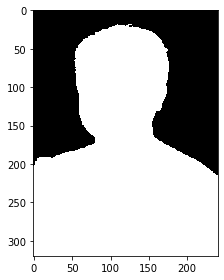

In [27]:
io.imshow(torch.squeeze(test_dataset[1][1]).numpy(), cmap='gray')
io.show()

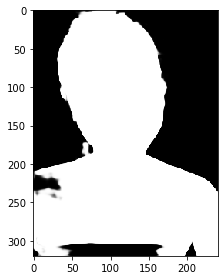

In [28]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[2][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

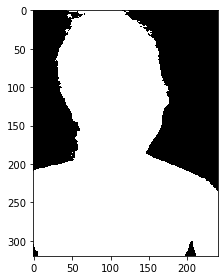

In [29]:
io.imshow(torch.squeeze(test_dataset[2][1]).numpy(), cmap='gray')
io.show()

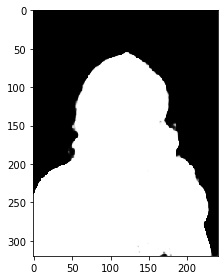

In [31]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[30][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

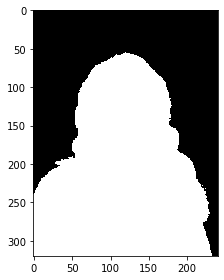

In [32]:
io.imshow(torch.squeeze(test_dataset[30][1]).numpy(), cmap='gray')
io.show()

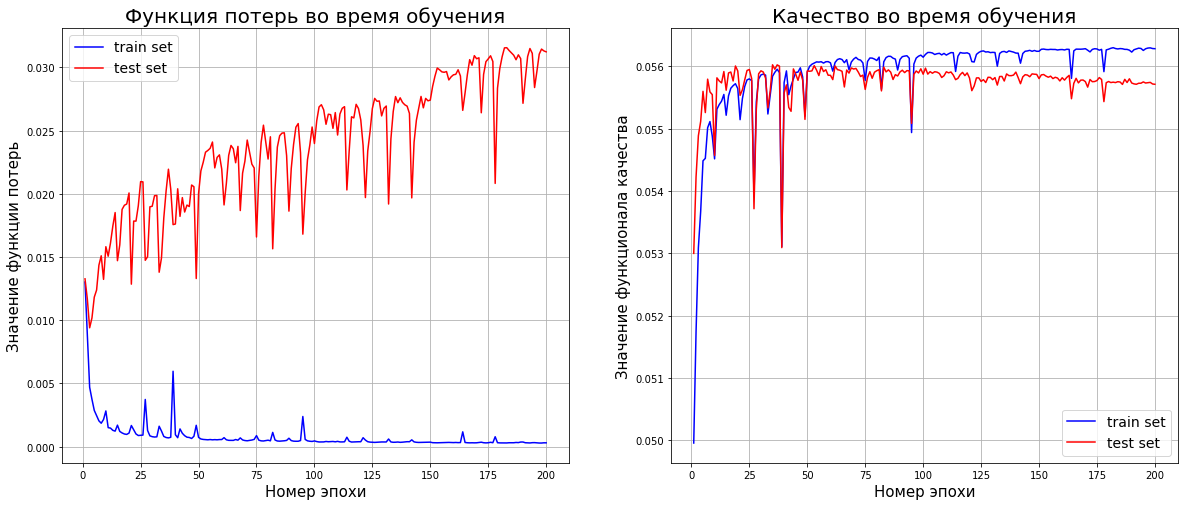

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(1, 201), loss_train, color='blue', label='train set')
plt.plot(np.arange(1, 201), loss_test, color='red', label='test set')
plt.title('Функция потерь во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.plot(np.arange(1, 201), qual_train, color='blue', label='train set')
plt.plot(np.arange(1, 201), qual_test, color='red', label='test set')
plt.title('Качество во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функционала качества', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.show()

## UNet c DiceLoss

In [39]:
model = torch.load('models_unet/model3')
f = open('lists_unet/loss_train3', 'rb')
loss_train = pickle.load(f)
f = open('lists_unet/loss_test3', 'rb')
loss_test = pickle.load(f)
f = open('lists_unet/qual_traint3', 'rb')
qual_train = pickle.load(f)
f = open('lists_unet/qual_test3', 'rb')
qual_test = pickle.load(f)
f.close()

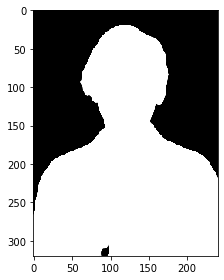

In [40]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[0][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

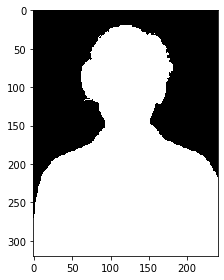

In [41]:
io.imshow(torch.squeeze(test_dataset[0][1]).numpy(), cmap='gray')
io.show()

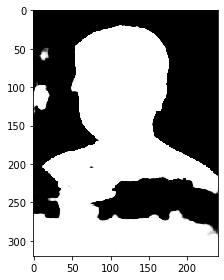

In [42]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[1][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

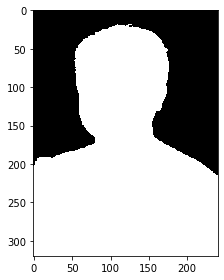

In [43]:
io.imshow(torch.squeeze(test_dataset[1][1]).numpy(), cmap='gray')
io.show()

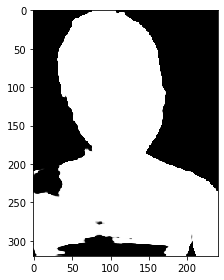

In [44]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[2][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

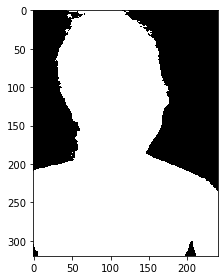

In [45]:
io.imshow(torch.squeeze(test_dataset[2][1]).numpy(), cmap='gray')
io.show()

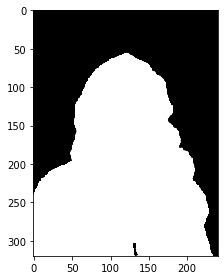

In [46]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[30][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

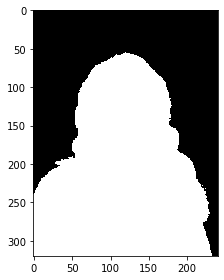

In [47]:
io.imshow(torch.squeeze(test_dataset[30][1]).numpy(), cmap='gray')
io.show()

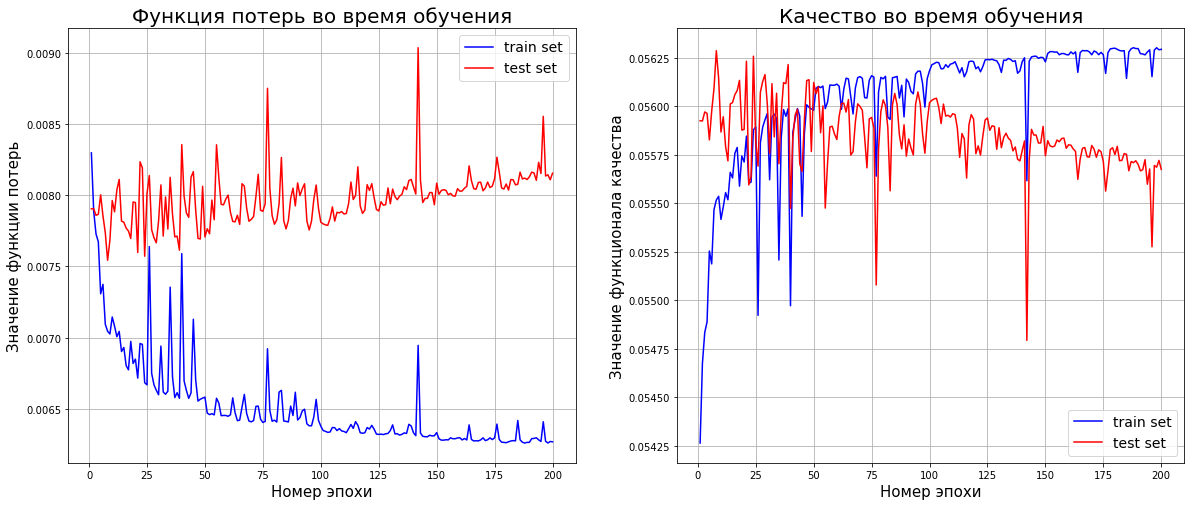

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(1, 201), loss_train, color='blue', label='train set')
plt.plot(np.arange(1, 201), loss_test, color='red', label='test set')
plt.title('Функция потерь во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.plot(np.arange(1, 201), qual_train, color='blue', label='train set')
plt.plot(np.arange(1, 201), qual_test, color='red', label='test set')
plt.title('Качество во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функционала качества', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.show()

## UNet c DiceBCELoss

In [49]:
model = torch.load('models_unet/model5')
f = open('lists_unet/loss_train5', 'rb')
loss_train = pickle.load(f)
f = open('lists_unet/loss_test5', 'rb')
loss_test = pickle.load(f)
f = open('lists_unet/qual_train5', 'rb')
qual_train = pickle.load(f)
f = open('lists_unet/qual_test5', 'rb')
qual_test = pickle.load(f)
f.close()

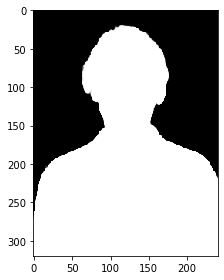

In [50]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[0][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

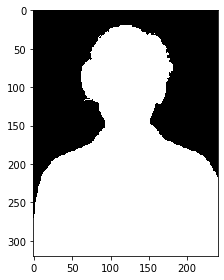

In [51]:
io.imshow(torch.squeeze(test_dataset[0][1]).numpy(), cmap='gray')
io.show()

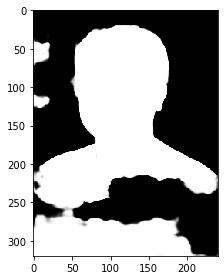

In [52]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[1][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

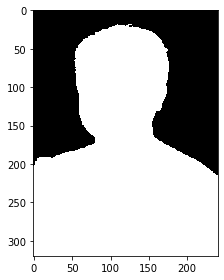

In [53]:
io.imshow(torch.squeeze(test_dataset[1][1]).numpy(), cmap='gray')
io.show()

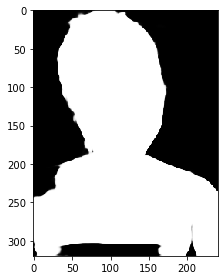

In [54]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[2][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

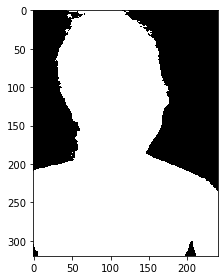

In [55]:
io.imshow(torch.squeeze(test_dataset[2][1]).numpy(), cmap='gray')
io.show()

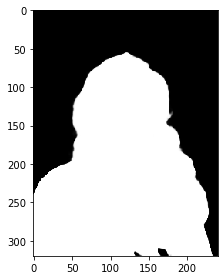

In [56]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[30][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

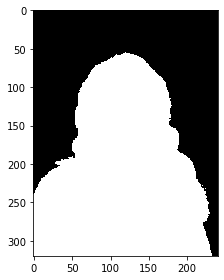

In [57]:
io.imshow(torch.squeeze(test_dataset[30][1]).numpy(), cmap='gray')
io.show()

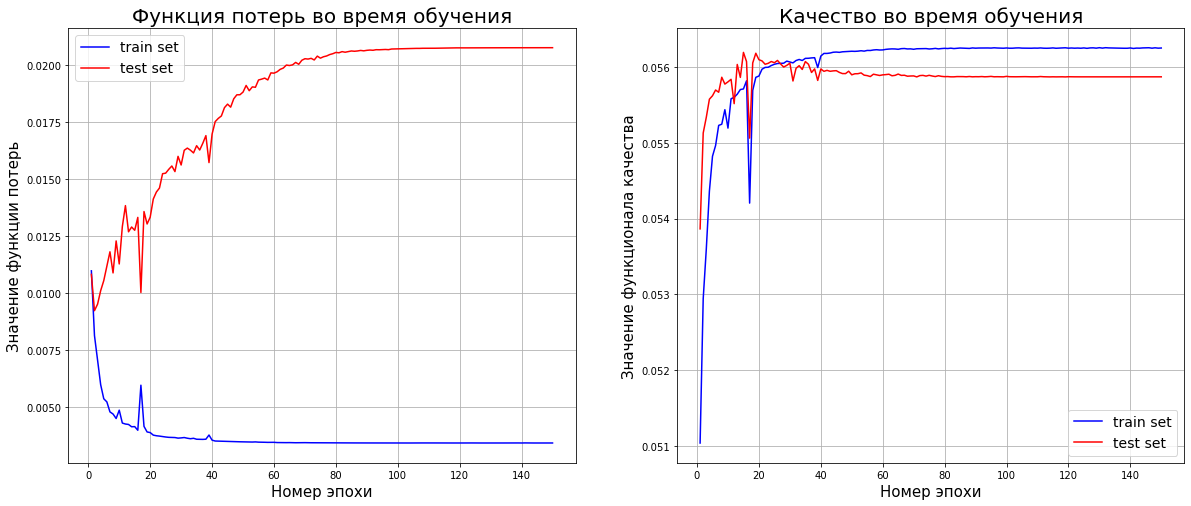

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(1, 151), loss_train, color='blue', label='train set')
plt.plot(np.arange(1, 151), loss_test, color='red', label='test set')
plt.title('Функция потерь во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.plot(np.arange(1, 151), qual_train, color='blue', label='train set')
plt.plot(np.arange(1, 151), qual_test, color='red', label='test set')
plt.title('Качество во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функционала качества', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.show()

## Вывод:

Лучшей функцией потерь оказалась сумма двух функций потерь: BCEWithLogitsLoss и DiceLoss с весами 0.5, причем как с точки зрения качества, так и с точки зрения скорости и стабильности обучения.

## LinkNet (2 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [62]:
class VGG13Encoder(torch.nn.Module):
    
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

In [63]:
class DecoderBlock(torch.nn.Module):
    
    def __init__(self, out_channels):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels // 2,
            kernel_size=1, padding=0
        )
        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels // 2, out_channels=out_channels // 2,
            kernel_size=3, padding=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels // 2, out_channels=out_channels,
            kernel_size=1, padding=0
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = self.relu(self.conv1(down))
        x = torch.nn.functional.interpolate(x, scale_factor=2)
        x = self.relu(self.upconv(x))
        x = self.relu(self.conv2(x))
        x = x + left
        return x

In [64]:
class Decoder(nn.Module):
    
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [65]:
class LinkNet(torch.nn.Module):
    
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [99]:
linkNet1 = LinkNet()

In [100]:
num_epoch = 150
lr = 0.0001
weight_decay = 0.0001
step_size = 20
gamma = 0.5
criterion = nn.BCEWithLogitsLoss()
val_criterion = DiceQual()
optimizer = torch.optim.Adam(linkNet1.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_train = []
loss_test = []
qual_train = []
qual_test = []

In [101]:
train(linkNet1, train_data_loader, device, loss_train=loss_train, loss_test=loss_test, qual_train=qual_train, qual_test=qual_test, name='models_linknet/model1')

0.015451472980117424   0.04669061999208677
0.012029164520999868   0.048544830996342096
0.012160996483297062   0.05010083402571898
0.01349947427539292   0.04768771333830162
0.007849837661564526   0.050889548714893255
0.006570660331861369   0.05234995399536867
0.005242688991714331   0.05297258604497039
0.004337829434412501   0.053349270597758305
0.0036878533920929406   0.05391179820681694
0.0033492007940802886   0.05398122463247376
0.002922751149299744   0.05440386427864359
0.002607735146707156   0.0545644408879734
0.0028762307060997607   0.054403604714746444
0.0022809827769718063   0.05476475052966922
0.0021285174005062587   0.05494142732454119
0.0019652754899161895   0.05505856969581151
0.0019049124076589577   0.054990838054234895
0.002486449190606459   0.05469594787627137
0.0016146189998378347   0.05518814742974608
0.0014244543340046166   0.05536936112369709
0.0012606540658274506   0.05551285038576978
0.001169014787456794   0.05557594465144834
0.001139735130563934   0.0556172714353894

In [102]:
f = open('lists_linknet/loss_train1', 'wb')
pickle.dump(loss_train, f)
f.close()
f = open('lists_linknet/loss_test1', 'wb')
pickle.dump(loss_test, f)
f.close()
f = open('lists_linknet/qual_train1', 'wb')
pickle.dump(qual_train, f)
f.close()
f = open('lists_linknet/qual_test1', 'wb')
pickle.dump(qual_test, f)
f.close()

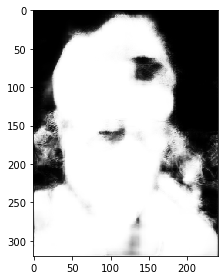

In [84]:
linkNet1 = linkNet1.to(device)
linkNet1.eval()
img = torch.unsqueeze(test_dataset[50][0], 0).to(device)
with torch.no_grad():
    res = linkNet1(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
# res = torch.squeeze(res).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

In [103]:
linkNet1 = LinkNet()

In [104]:
num_epoch = 150
lr = 0.0001
weight_decay = 0.0001
step_size = 20
gamma = 0.5
criterion = DiceLoss(reduction='mean')
val_criterion = DiceQual()
optimizer = torch.optim.Adam(linkNet1.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_train = []
loss_test = []
qual_train = []
qual_test = []

In [105]:
train(linkNet1, train_data_loader, device, loss_train=loss_train, loss_test=loss_test, qual_train=qual_train, qual_test=qual_test, name='models_linknet/model2')

0.007632120670540527   0.054929217234093025
0.007024568641764844   0.05553676886986703
0.007058642009022747   0.05550269569042737
0.006805512479253267   0.05575582556155994
0.006774698983662203   0.055786639027904365
0.006869241729163006   0.05569209633678403
0.0070628998417250075   0.05549843809672497
0.00664879696377872   0.05591254100071904
0.006951370944156585   0.055609966693144434
0.006826403999556737   0.055734934133566165
0.006701572662012851   0.05585976493370311
0.006713248650845912   0.05584808922317007
0.006574045853475447   0.055987291893500456
0.0066264900168672685   0.055934848258376
0.0069736972194388   0.05558764051291379
0.006838036360177079   0.055723301240108665
0.0065961373143695054   0.055965200417526104
0.006646196040305674   0.055915141728605205
0.006935290049969916   0.055626048043852815
0.007048825122840096   0.05551251301119676
0.0064980946065377266   0.05606324312672882
0.006450244908744763   0.056111093343649575
0.006435108945958163   0.056126228945879986
0

In [106]:
f = open('lists_linknet/loss_train2', 'wb')
pickle.dump(loss_train, f)
f.close()
f = open('lists_linknet/loss_test2', 'wb')
pickle.dump(loss_test, f)
f.close()
f = open('lists_linknet/qual_train2', 'wb')
pickle.dump(qual_train, f)
f.close()
f = open('lists_linknet/qual_test2', 'wb')
pickle.dump(qual_test, f)
f.close()

In [107]:
linkNet1 = LinkNet()

In [108]:
num_epoch = 150
lr = 0.0001
weight_decay = 0.0001
step_size = 20
gamma = 0.5
criterion = DiceBCELoss()
val_criterion = DiceQual()
optimizer = torch.optim.Adam(linkNet1.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
loss_train = []
loss_test = []
qual_train = []
qual_test = []

In [109]:
train(linkNet1, train_data_loader, device, loss_train=loss_train, loss_test=loss_test, qual_train=qual_train, qual_test=qual_test, name='models_linknet/model3')

0.014250507846957217   0.048724813962591054
0.01190396946497532   0.050501191975791976
0.010614013273755163   0.05148720890429818
0.009460083776545712   0.052207357150532666
0.009396255853511868   0.05202772480758296
0.00804706898511509   0.05319976964572461
0.006841173870772328   0.053850738600379
0.007033832095219764   0.0535694498338456
0.00627103953332557   0.05437389351025414
0.006286480499685571   0.0542374643861838
0.005275625918312794   0.0548893947508899
0.005333551999009685   0.05491772949169148
0.006216518187911868   0.05429705971590553
0.0047879406265636595   0.05519174052524847
0.0046015407796857755   0.055387501949416995
0.004464651426433844   0.0554595462853588
0.004584234071688926   0.05534299747457214
0.004584685629699836   0.055378640320981914
0.004638510862213648   0.05533312220159293
0.004431282274308043   0.05547750670320269
0.0040857436462608   0.05573163094534607
0.004046386364624416   0.05575473896128156
0.0039921218759660865   0.055788859242428976
0.00394494957

In [110]:
f = open('lists_linknet/loss_train3', 'wb')
pickle.dump(loss_train, f)
f.close()
f = open('lists_linknet/loss_test3', 'wb')
pickle.dump(loss_test, f)
f.close()
f = open('lists_linknet/qual_train3', 'wb')
pickle.dump(qual_train, f)
f.close()
f = open('lists_linknet/qual_test3', 'wb')
pickle.dump(qual_test, f)
f.close()

## LinkNet c BCEWithLogitsLoss

In [66]:
model = torch.load('models_linknet/model1')
f = open('lists_linknet/loss_train1', 'rb')
loss_train = pickle.load(f)
f = open('lists_linknet/loss_test1', 'rb')
loss_test = pickle.load(f)
f = open('lists_linknet/qual_train1', 'rb')
qual_train = pickle.load(f)
f = open('lists_linknet/qual_test1', 'rb')
qual_test = pickle.load(f)
f.close()

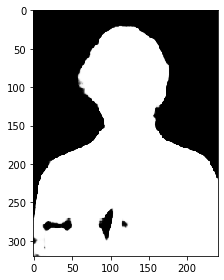

In [67]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[0][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

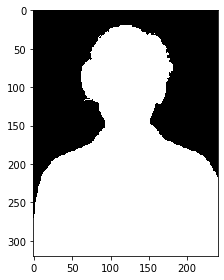

In [68]:
io.imshow(torch.squeeze(test_dataset[0][1]).numpy(), cmap='gray')
io.show()

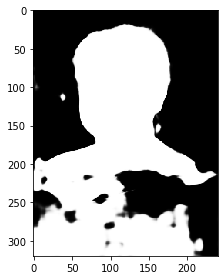

In [69]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[1][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

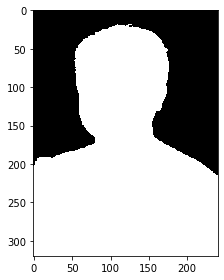

In [70]:
io.imshow(torch.squeeze(test_dataset[1][1]).numpy(), cmap='gray')
io.show()

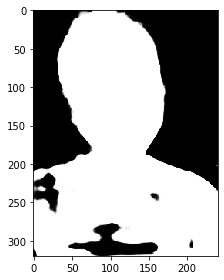

In [71]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[2][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

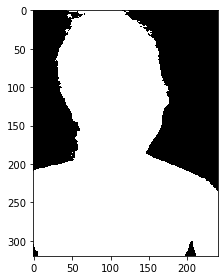

In [72]:
io.imshow(torch.squeeze(test_dataset[2][1]).numpy(), cmap='gray')
io.show()

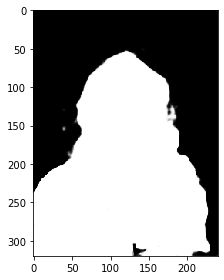

In [73]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[30][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

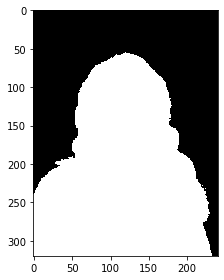

In [74]:
io.imshow(torch.squeeze(test_dataset[30][1]).numpy(), cmap='gray')
io.show()

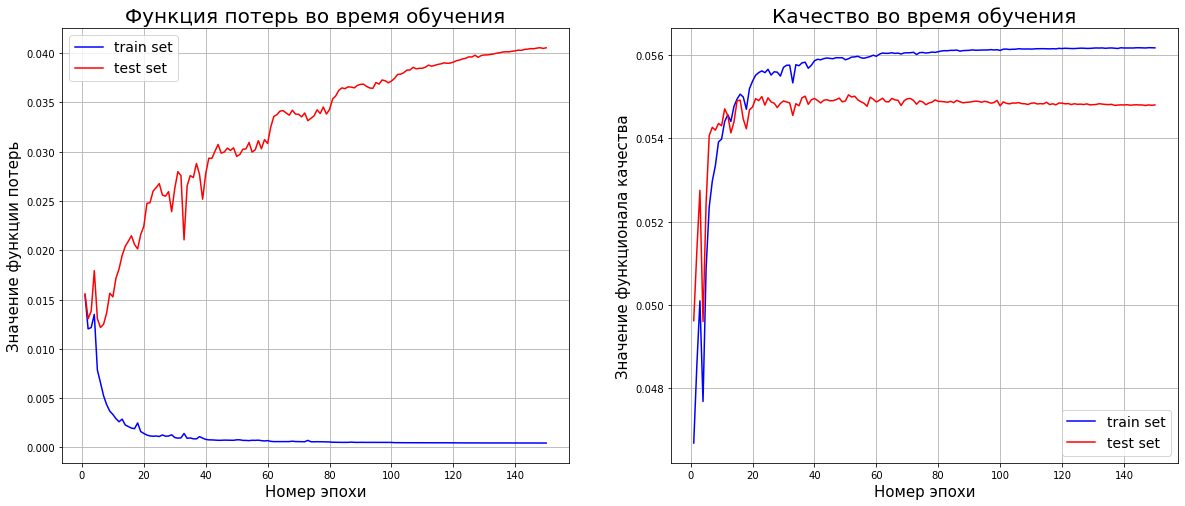

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(1, 151), loss_train, color='blue', label='train set')
plt.plot(np.arange(1, 151), loss_test, color='red', label='test set')
plt.title('Функция потерь во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.plot(np.arange(1, 151), qual_train, color='blue', label='train set')
plt.plot(np.arange(1, 151), qual_test, color='red', label='test set')
plt.title('Качество во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функционала качества', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.show()

## LinkNet c DiceLoss

In [76]:
model = torch.load('models_linknet/model2')
f = open('lists_linknet/loss_train2', 'rb')
loss_train = pickle.load(f)
f = open('lists_linknet/loss_test2', 'rb')
loss_test = pickle.load(f)
f = open('lists_linknet/qual_train2', 'rb')
qual_train = pickle.load(f)
f = open('lists_linknet/qual_test2', 'rb')
qual_test = pickle.load(f)
f.close()

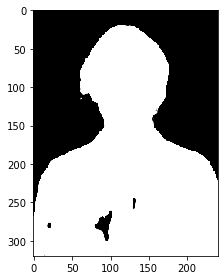

In [77]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[0][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

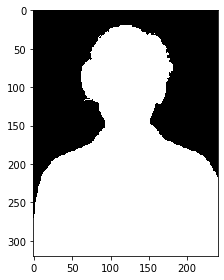

In [78]:
io.imshow(torch.squeeze(test_dataset[0][1]).numpy(), cmap='gray')
io.show()

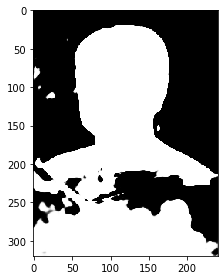

In [79]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[1][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

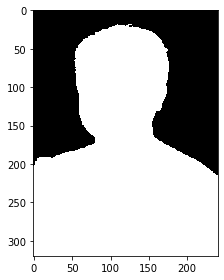

In [80]:
io.imshow(torch.squeeze(test_dataset[1][1]).numpy(), cmap='gray')
io.show()

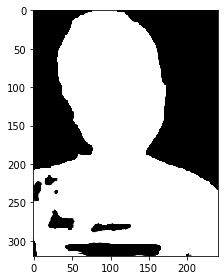

In [81]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[2][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

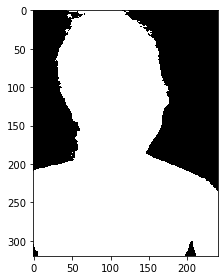

In [82]:
io.imshow(torch.squeeze(test_dataset[2][1]).numpy(), cmap='gray')
io.show()

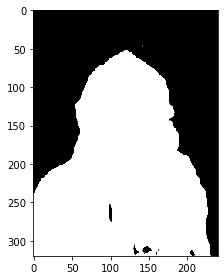

In [83]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[30][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

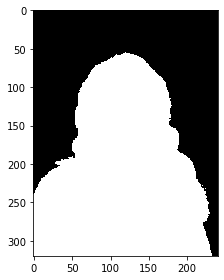

In [84]:
io.imshow(torch.squeeze(test_dataset[30][1]).numpy(), cmap='gray')
io.show()

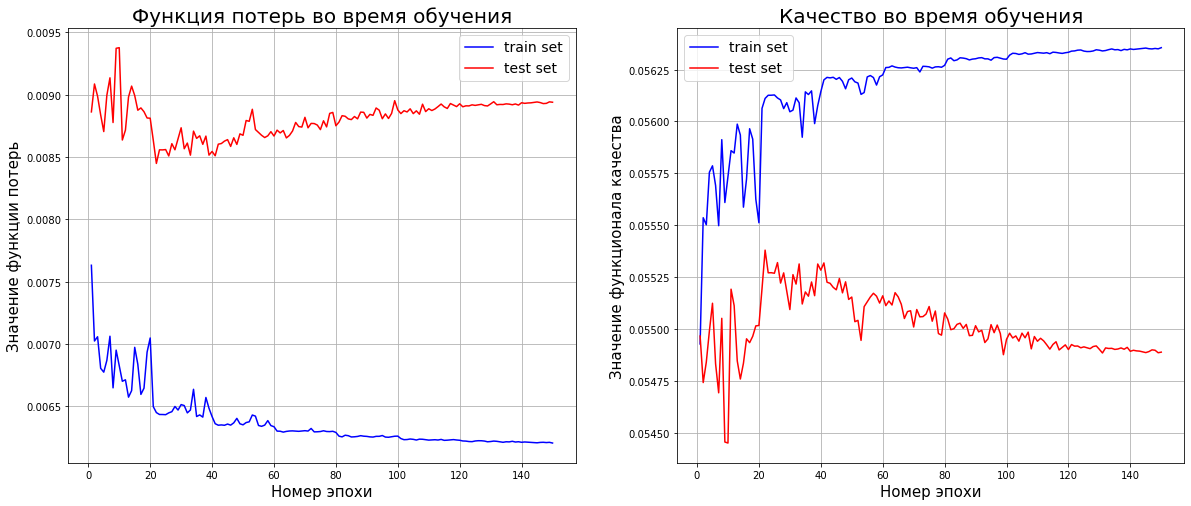

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(1, 151), loss_train, color='blue', label='train set')
plt.plot(np.arange(1, 151), loss_test, color='red', label='test set')
plt.title('Функция потерь во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.plot(np.arange(1, 151), qual_train, color='blue', label='train set')
plt.plot(np.arange(1, 151), qual_test, color='red', label='test set')
plt.title('Качество во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функционала качества', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.show()

## LinkNet c DiceBCELoss

In [86]:
model = torch.load('models_linknet/model3')
f = open('lists_linknet/loss_train3', 'rb')
loss_train = pickle.load(f)
f = open('lists_linknet/loss_test3', 'rb')
loss_test = pickle.load(f)
f = open('lists_linknet/qual_train3', 'rb')
qual_train = pickle.load(f)
f = open('lists_linknet/qual_test3', 'rb')
qual_test = pickle.load(f)
f.close()

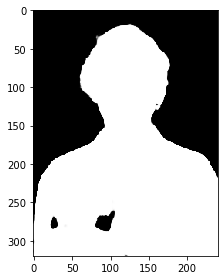

In [87]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[0][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

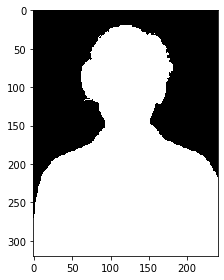

In [88]:
io.imshow(torch.squeeze(test_dataset[0][1]).numpy(), cmap='gray')
io.show()

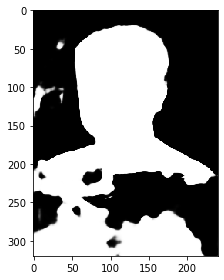

In [89]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[1][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

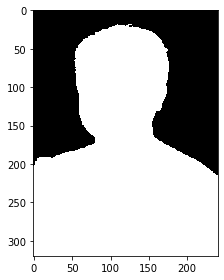

In [90]:
io.imshow(torch.squeeze(test_dataset[1][1]).numpy(), cmap='gray')
io.show()

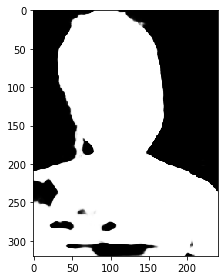

In [91]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[2][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

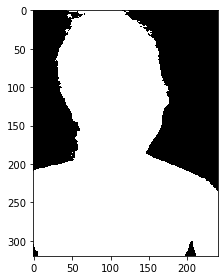

In [92]:
io.imshow(torch.squeeze(test_dataset[2][1]).numpy(), cmap='gray')
io.show()

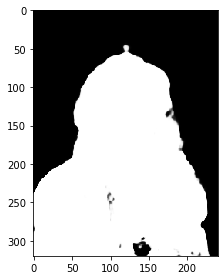

In [93]:
model = model.to(device)
model.eval()
img = torch.unsqueeze(test_dataset[30][0], 0).to(device)
with torch.no_grad():
    res = model(img)
res = torch.sigmoid(torch.squeeze(res)).cpu().numpy()
io.imshow(res, cmap='gray')
io.show()

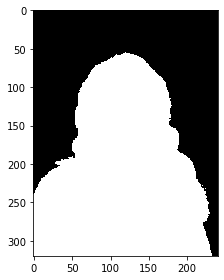

In [94]:
io.imshow(torch.squeeze(test_dataset[30][1]).numpy(), cmap='gray')
io.show()

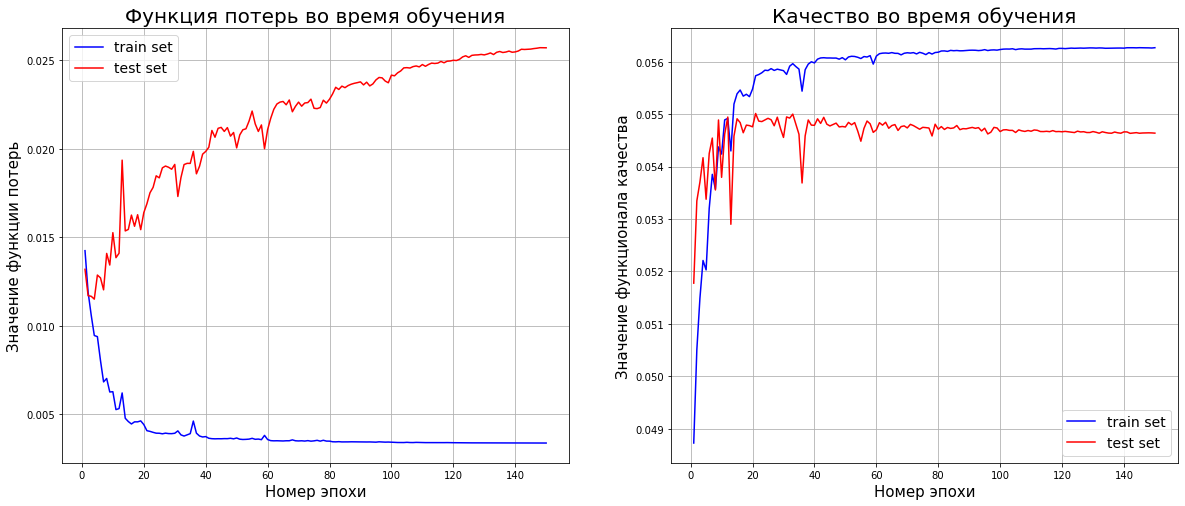

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.subplot(121)
plt.plot(np.arange(1, 151), loss_train, color='blue', label='train set')
plt.plot(np.arange(1, 151), loss_test, color='red', label='test set')
plt.title('Функция потерь во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.subplot(122)
plt.plot(np.arange(1, 151), qual_train, color='blue', label='train set')
plt.plot(np.arange(1, 151), qual_test, color='red', label='test set')
plt.title('Качество во время обучения', fontsize=20)
plt.xlabel('Номер эпохи', fontsize=15)
plt.ylabel('Значение функционала качества', fontsize=15)
plt.grid()
plt.legend(prop={'size': 14})
plt.show()

## Вывод:

Лучшей стратегией оптимизации для LinkNet так же оказаласть смесь в равной пропорции двух функций потерь: BCEWithLogitsLoss и DiceLoss.

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

## Вывод:

По качеству UNet лучше чем LinkNet, но LinkNet существенно быстрее обучается.

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура сверточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

1. Входными данными являются изображения, среди нейронов (пикселей) существует локальная зависимость.
2. Намного меньше параметров для обучения (не надо делать связь всех нейронов со всеми). Свертки находят важные признаки в изображениях, а не запоминают их попиксельно. Свертка с определенным ядром выделяет свои определенные признаки.
3. Например любые табличные данные. В общем случае в векторе признаков все признаки зависят от всех остальных, следовательно надо смотреть не только на соседние признаки в векторе, а на все. То есть должен быть не сверточный, а полносвязный слой.

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

1. f(): 1000. g(): 100 * 10
2. f(): 100000. g(): 30
3. f(): 100000 умножений, 99000 сложений, 1000 нелинейностей. g(): 3000 умножений, 2000 сложений, 1000 нелинейностей.

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: catalyst, pytorch-lightning, kekas.